# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [4]:
default_seed = 1
output_file = "output_sample"

In [5]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [6]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [7]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where(data['loan_status'].isin(['Charged Off','Default']),False,True)

In [8]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [9]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True,False],size = (len(data)),p=[0.7,0.3])

In [10]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [11]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [12]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [12]:
def fit_classification_over_iterations(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
    
    np.random.seed(default_seed)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    

    if model_name != None:
        print("  Model: " + model_name)

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print(cv_model.best_params_)
    print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    print("ROC Area under curve score : " + str(roc_auc_score(y_test, y_pred_probs)))
    return roc_auc_score(y_test, y_pred_probs)

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [13]:
## define your set of features to use in different models
your_features = ['id','loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
                 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
                 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
                 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries','ret_OPT','return_PESS','return_INTa','return_INTb']

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Gaussian NB
Fit time: 3.49 seconds
Optimal parameters:
{'var_smoothing': 1e-06}

Accuracy-maximizing threshold was: 5.618536005850142e-16
Accuracy:  0.7977
              precision    recall  f1-score   support

  No default     0.6218    0.0182    0.0353      4075
     Default     0.7988    0.9972    0.8870     15925

   micro avg     0.7977    0.7977    0.7977     20000
   macro avg     0.7103    0.5077    0.4611     20000
weighted avg     0.7627    0.7977    0.7135     20000



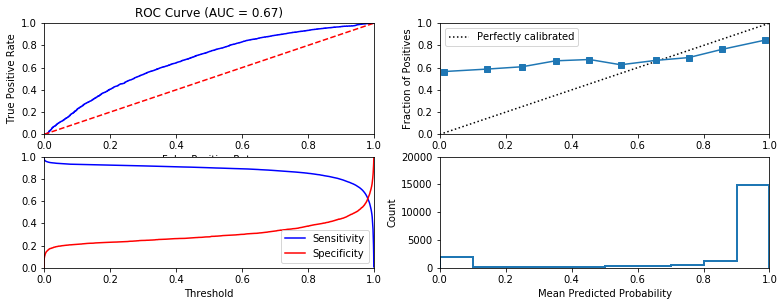


Similarity to LC grade ranking:  -0.6309958531384506
Brier score: 0.20169898446568532
Were parameters on edge? : False
Score variations around CV search grid : 0.17024620220010056
[0.7623 0.7635 0.7636 0.7636 0.7636 0.7636]


In [14]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
# gnb.get_params().keys()
gnb = fit_classification(gnb,data_dict,cv_parameters = {"var_smoothing" : [1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]}, 
                         model_name = 'Gaussian NB')

### $l_1$ regularized logistic regression

  Model: L1 Logistic
Fit time: 33.85 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.4887141651308131
Accuracy:  0.8033
             precision    recall  f1-score   support

 No default     0.6093    0.0964    0.1665      4075
    Default     0.8098    0.9842    0.8885     15925

avg / total     0.7689    0.8033    0.7414     20000



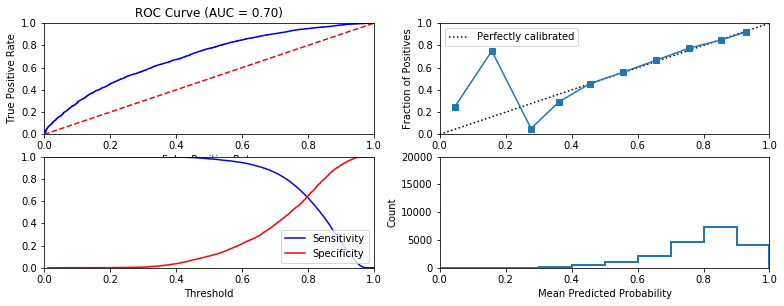


Similarity to LC grade ranking:  -0.7211943787161031
Brier score: 0.14712870165867456
Were parameters on edge? : True
Score variations around CV search grid : 74.32291883346508
[0.80123333 0.80093333 0.79886667 0.79426667 0.20573333]


In [15]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression('l1')
cv_parameters = {'C' : [10, 1, .1, .001,.0001]}

l1_logistic = fit_classification(l1_logistic,data_dict,cv_parameters,model_name = 'L1 Logistic')

### $l_2$ regularized logistic regression

  Model: L2 Logistic
Fit time: 2.07 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.4915898933446157
Accuracy:  0.80325
             precision    recall  f1-score   support

 No default     0.6070    0.0974    0.1679      4075
    Default     0.8099    0.9839    0.8884     15925

avg / total     0.7686    0.8033    0.7416     20000



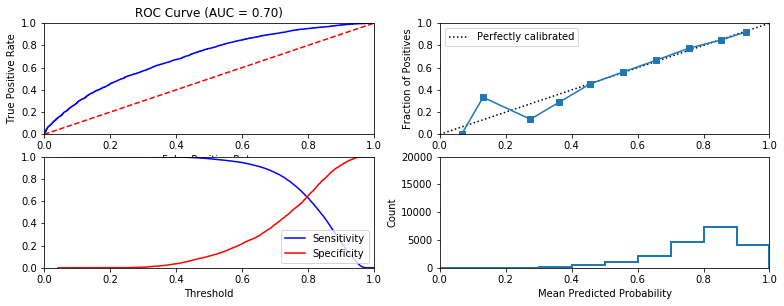


Similarity to LC grade ranking:  -0.7218917769471336
Brier score: 0.14705698246389742
Were parameters on edge? : True
Score variations around CV search grid : 0.8653686137460492
[0.8012     0.8005     0.79923333 0.79426667 0.79426667]


In [16]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression('l2')
cv_parameters = {'C' : [10, 1, .1, .001,.0001]}

l2_logistic = fit_classification(l2_logistic,data_dict,cv_parameters, model_name = 'L2 Logistic')

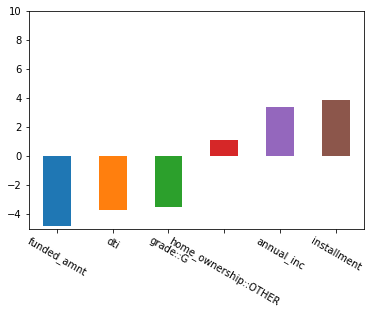

In [17]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree Classifier
Fit time: 1.12 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 0.6204131227217496
Accuracy:  0.7695
             precision    recall  f1-score   support

 No default     0.4090    0.2950    0.3427      4075
    Default     0.8316    0.8909    0.8602     15925

avg / total     0.7455    0.7695    0.7548     20000



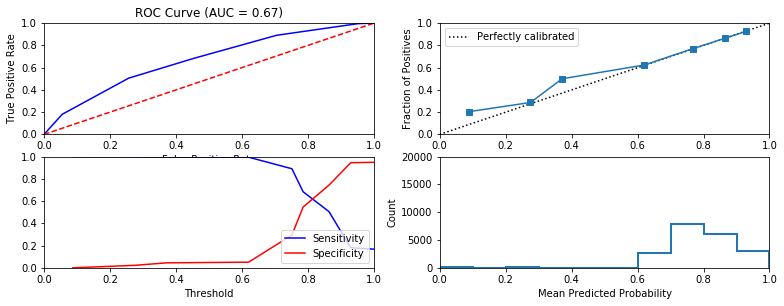


Similarity to LC grade ranking:  -0.8926660110640637
Brier score: 0.1502931870967491
Were parameters on edge? : False
Score variations around CV search grid : 0.9189571291945569
[0.79426667 0.80163333 0.79826667 0.79433333]


In [18]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth' :[1,3,5,7]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, model_name = 'Decision Tree Classifier')

### Random forest

  Model: Random Forest Classifier
Fit time: 93.15 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.5742297813292151
Accuracy:  0.8045
             precision    recall  f1-score   support

 No default     0.6187    0.1055    0.1803      4075
    Default     0.8112    0.9834    0.8890     15925

avg / total     0.7720    0.8045    0.7446     20000



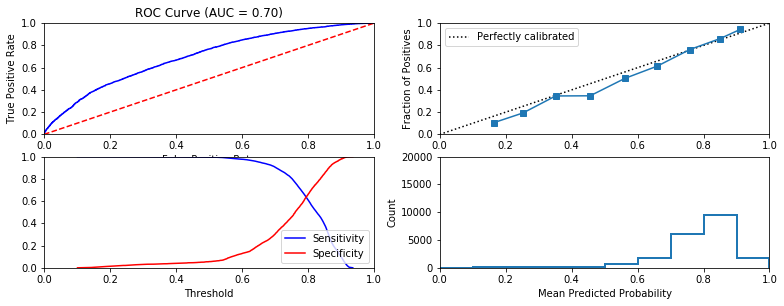


Similarity to LC grade ranking:  -0.7655807383967009
Brier score: 0.1470691434885237
Were parameters on edge? : True
Score variations around CV search grid : 0.9271963743711229
[0.79426667 0.79426667 0.79426667 0.79426667 0.7986     0.79873333
 0.79923333 0.79936667 0.80126667 0.8008     0.8009     0.80073333
 0.8014     0.8017     0.80136667 0.80163333]


In [19]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name = 'Random Forest Classifier')

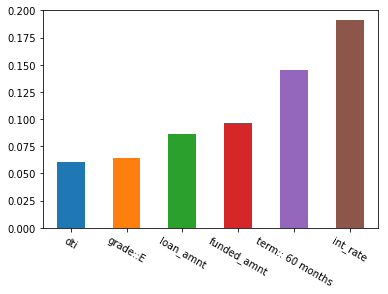

In [20]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP Classifier
Fit time: 191.44 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

Accuracy-maximizing threshold was: 0.481566599276984
Accuracy:  0.80235
             precision    recall  f1-score   support

 No default     0.5897    0.0984    0.1687      4075
    Default     0.8098    0.9825    0.8878     15925

avg / total     0.7650    0.8024    0.7413     20000



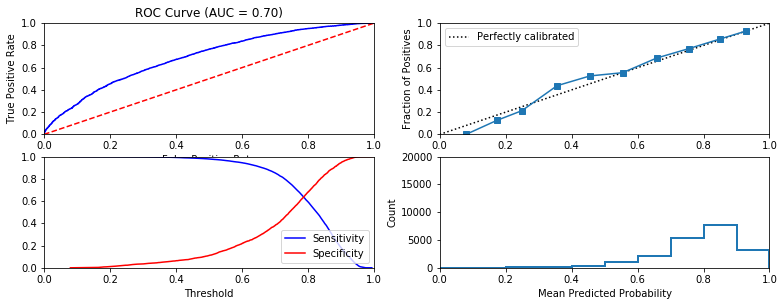


Similarity to LC grade ranking:  -0.7211543627328748
Brier score: 0.14737533250060797
Were parameters on edge? : True
Score variations around CV search grid : 0.8406158967956765
[0.7996     0.79883333 0.7985     0.79786667 0.79426667 0.7983
 0.7992     0.7973     0.79426667 0.79426667 0.799      0.79906667
 0.79813333 0.79693333 0.79426667 0.79473333 0.79556667 0.801
 0.79753333 0.79426667]


In [21]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : [0.00001, 0.001, 0.1, 1, 10]}

mlp = fit_classification(mlp, data_dict, cv_parameters, model_name = 'MLP Classifier')

## Train and Test logistic regression model with features derived by LendingClub

  Model: L1 Logistic with 1 lending club defined feature
Fit time: 0.55 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 0.7609328628689609
Accuracy:  0.20375
             precision    recall  f1-score   support

 No default     0.2037    1.0000    0.3385      4075
    Default     0.0000    0.0000    0.0000     15925

avg / total     0.0415    0.2037    0.0690     20000



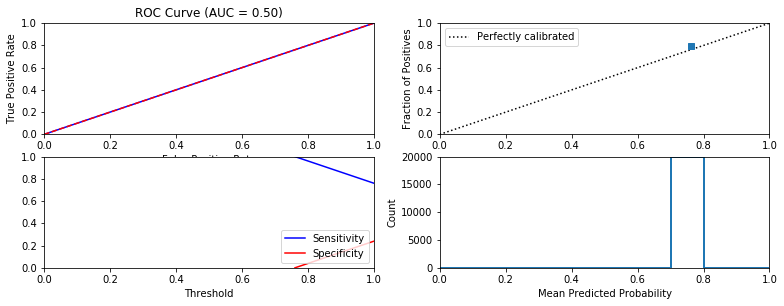


Similarity to LC grade ranking:  nan
Brier score: 0.16348323767513265
Were parameters on edge? : False
Score variations around CV search grid : 74.09770018465672
[0.79196667 0.792      0.79283333 0.79426667 0.20573333]


In [22]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'int_rate'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression('l1') # using the optimal parameter

lc1_only_logistic = fit_classification(lc1_only_logistic,data_dict,cv_parameters = {'C' : [10, 1, .1, .001,.0001]},model_name='L1 Logistic with 1 lending club defined feature')

  Model: L2 Logistic with 1 lending club defined feature
Fit time: 0.35 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 0.7412940085864302
Accuracy:  0.7959
             precision    recall  f1-score   support

 No default     0.4639    0.0110    0.0216      4075
    Default     0.7975    0.9967    0.8861     15925

avg / total     0.7295    0.7959    0.7099     20000



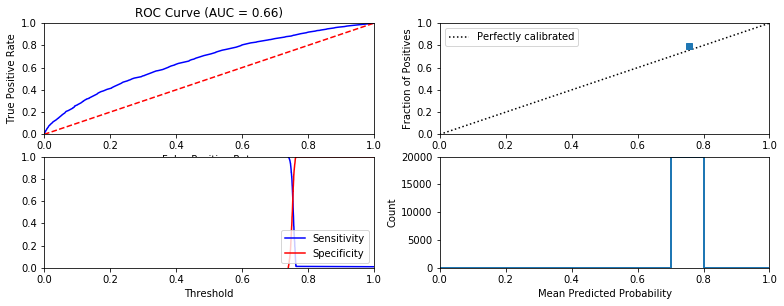


Similarity to LC grade ranking:  -0.8499547472907161
Brier score: 0.16298957776132056
Were parameters on edge? : False
Score variations around CV search grid : 0.2937720329024633
[0.79196667 0.79193333 0.79373333 0.79426667 0.79426667]


In [23]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression('l2')

lc2_only_logistic = fit_classification(lc2_only_logistic,data_dict,cv_parameters = {'C' : [10, 1, .1, .001,.0001]}, model_name='L2 Logistic with 1 lending club defined feature')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [14]:
lending_club_features = ['int_rate','grade','sub_grade','dti','verification_status','installment','expDefaultRate','revol_util','sec_app_revol_util','ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
final_features = list(set(your_features)-set(lending_club_features))

In [16]:
#Naive Bayes
out_gnb = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    gnb = GaussianNB()
    print('Running iteration ' + str(i+1) + '......')
    out_gnb.append(fit_classification_over_iterations(gnb,data_dict,cv_parameters = {"var_smoothing" : [1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]},model_name = 'Gaussian NB',random_state = i+1))
print()
print("Mean auc of all models : " + str(np.mean(out_gnb)))
print("Standard deviation of auc of all models : " + str(np.std(out_gnb)))

Running iteration 1......
  Model: Gaussian NB
Fit time: 2.61 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6342922633895465
Running iteration 2......
  Model: Gaussian NB
Fit time: 2.61 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6354162913100931
Running iteration 3......
  Model: Gaussian NB
Fit time: 2.63 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6445101995649283
Running iteration 4......
  Model: Gaussian NB
Fit time: 2.62 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6463203275392708
Running iteration 5......
  Model: Gaussian NB
Fit time: 2.62 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6474391450268815
Running iteration 6......
  Model: Gaussian NB
Fit time: 2.63 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6340639127762293
Running it

Running iteration 51......
  Model: Gaussian NB
Fit time: 2.75 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6516615431814694
Running iteration 52......
  Model: Gaussian NB
Fit time: 2.88 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6267773021660757
Running iteration 53......
  Model: Gaussian NB
Fit time: 2.74 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6371204758388925
Running iteration 54......
  Model: Gaussian NB
Fit time: 2.73 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.647001872276083
Running iteration 55......
  Model: Gaussian NB
Fit time: 3.3 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6380278531527045
Running iteration 56......
  Model: Gaussian NB
Fit time: 2.74 seconds
Optimal parameters:
{'var_smoothing': 0.0001}

ROC Area under curve score : 0.6505219102482449
Runnin

In [26]:
# l_1 regularized logistic regression classifier

out_l1 = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    print('Running iteration ' + str(i+1) + '......')
    l1_logistic = LogisticRegression('l1')
    cv_parameters = {'C' : [10, 1, .1, .001,.0001]}
    out_l1.append(fit_classification_over_iterations(l1_logistic,data_dict,cv_parameters,model_name = 'L1 Logistic' ,random_state = i+1))

print()
print("Mean auc of all models : " + str(np.mean(out_l1)))
print("Standard deviation of auc of all models : " + str(np.std(out_l1)))

Running iteration 1......
  Model: L1 Logistic
Fit time: 21.81 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6709556413787789
Running iteration 2......
  Model: L1 Logistic
Fit time: 13.91 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6736054019640192
Running iteration 3......
  Model: L1 Logistic
Fit time: 27.4 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6789481765000623
Running iteration 4......
  Model: L1 Logistic
Fit time: 16.28 seconds
Optimal parameters:
{'C': 0.1}

ROC Area under curve score : 0.6770479592517211
Running iteration 5......
  Model: L1 Logistic
Fit time: 23.91 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6846016013917142
Running iteration 6......
  Model: L1 Logistic
Fit time: 17.89 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6757721876325171
Running iteration 7......
  Model: L1 Logistic
Fit time: 12.55 seconds
Optimal parameters:
{'C': 10}



Running iteration 56......
  Model: L1 Logistic
Fit time: 15.04 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6825730538143786
Running iteration 57......
  Model: L1 Logistic
Fit time: 17.29 seconds
Optimal parameters:
{'C': 0.1}

ROC Area under curve score : 0.6737758387830391
Running iteration 58......
  Model: L1 Logistic
Fit time: 16.55 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6729522085585777
Running iteration 59......
  Model: L1 Logistic
Fit time: 16.93 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6743104612669168
Running iteration 60......
  Model: L1 Logistic
Fit time: 9.87 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6721457310385603
Running iteration 61......
  Model: L1 Logistic
Fit time: 14.38 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6834909485756944
Running iteration 62......
  Model: L1 Logistic
Fit time: 17.36 seconds
Optimal parameters:
{'C'

In [27]:
#l_2 regularized logistic regression classifier

out_l2 = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    print('Running iteration ' + str(i+1) + '......')
    l2_logistic = LogisticRegression('l2')
    cv_parameters = {'C' : [10, 1, .1, .001,.0001]}
    out_l2.append(fit_classification_over_iterations(l2_logistic,data_dict,cv_parameters,model_name = 'L2 Logistic' ,random_state = i+1))

print()
print("Mean auc of all models : " + str(np.mean(out_l2)))
print("Standard deviation of auc of all models : " + str(np.std(out_l2)))

Running iteration 1......
  Model: L2 Logistic
Fit time: 1.49 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6704549662432221
Running iteration 2......
  Model: L2 Logistic
Fit time: 1.89 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6705705301510262
Running iteration 3......
  Model: L2 Logistic
Fit time: 1.91 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6739866700745937
Running iteration 4......
  Model: L2 Logistic
Fit time: 1.54 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6786891610310837
Running iteration 5......
  Model: L2 Logistic
Fit time: 1.82 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6838001292941857
Running iteration 6......
  Model: L2 Logistic
Fit time: 1.49 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6746106082212074
Running iteration 7......
  Model: L2 Logistic
Fit time: 1.56 seconds
Optimal parameters:
{'C': 0.1}

ROC Are

Running iteration 56......
  Model: L2 Logistic
Fit time: 1.53 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6817879397088433
Running iteration 57......
  Model: L2 Logistic
Fit time: 1.48 seconds
Optimal parameters:
{'C': 1}

ROC Area under curve score : 0.6747476768652977
Running iteration 58......
  Model: L2 Logistic
Fit time: 1.86 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6674599601139484
Running iteration 59......
  Model: L2 Logistic
Fit time: 1.83 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6689356795678453
Running iteration 60......
  Model: L2 Logistic
Fit time: 1.62 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.671848306236335
Running iteration 61......
  Model: L2 Logistic
Fit time: 1.61 seconds
Optimal parameters:
{'C': 10}

ROC Area under curve score : 0.6834952055291039
Running iteration 62......
  Model: L2 Logistic
Fit time: 1.72 seconds
Optimal parameters:
{'C': 10}



In [28]:
#decision tree classifier

out_dt = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    print('Running iteration ' + str(i+1) + '......')
    decision_tree = DecisionTreeClassifier()
    cv_parameters = {'max_depth' :[1,3,5,7]}
    out_dt.append(fit_classification_over_iterations(decision_tree,data_dict,cv_parameters,model_name = 'Decision Tree Classifier' ,random_state = i+1))

print()
print("Mean auc of all models : " + str(np.mean(out_dt)))
print("Standard deviation of auc of all models : " + str(np.std(out_dt)))

Running iteration 1......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6503637564889098
Running iteration 2......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6482253823727522
Running iteration 3......
  Model: Decision Tree Classifier
Fit time: 0.69 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6566510317333
Running iteration 4......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6499500608487041
Running iteration 5......
  Model: Decision Tree Classifier
Fit time: 0.73 seconds
Optimal parameters:
{'max_depth': 5}

ROC Area under curve score : 0.6666893906035802
Running iteration 6......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6532821721

Running iteration 50......
  Model: Decision Tree Classifier
Fit time: 0.71 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6541238743401812
Running iteration 51......
  Model: Decision Tree Classifier
Fit time: 0.71 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6501408191440405
Running iteration 52......
  Model: Decision Tree Classifier
Fit time: 0.74 seconds
Optimal parameters:
{'max_depth': 5}

ROC Area under curve score : 0.6533072875889872
Running iteration 53......
  Model: Decision Tree Classifier
Fit time: 0.71 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6492750039368436
Running iteration 54......
  Model: Decision Tree Classifier
Fit time: 0.71 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6550922733126618
Running iteration 55......
  Model: Decision Tree Classifier
Fit time: 0.71 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score :

Running iteration 99......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6546285647107277
Running iteration 100......
  Model: Decision Tree Classifier
Fit time: 0.7 seconds
Optimal parameters:
{'max_depth': 3}

ROC Area under curve score : 0.6487699315245579

Mean auc of all models : 0.6518583581598737
Standard deviation of auc of all models : 0.006114767359141585


In [29]:
#random forest classifier

out_rf = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    print('Running iteration ' + str(i+1) + '......')
    random_forest = RandomForestClassifier()
    cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}
    out_rf.append(fit_classification_over_iterations(random_forest, data_dict, cv_parameters, model_name = 'Random Forest Classifier' ,random_state = i+1))

print()
print("Mean auc of all models : " + str(np.mean(out_rf)))
print("Standard deviation of auc of all models : " + str(np.std(out_rf)))

Running iteration 1......
  Model: Random Forest Classifier
Fit time: 73.86 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 10}

ROC Area under curve score : 0.6682352823337924
Running iteration 2......
  Model: Random Forest Classifier
Fit time: 73.85 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

ROC Area under curve score : 0.677853121154639
Running iteration 3......
  Model: Random Forest Classifier
Fit time: 74.31 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 100}

ROC Area under curve score : 0.6802893061350264
Running iteration 4......
  Model: Random Forest Classifier
Fit time: 73.44 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

ROC Area under curve score : 0.6702486184265319
Running iteration 5......
  Model: Random Forest Classifier
Fit time: 78.59 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 400}

ROC Area under curve score : 0.6906827429608225
Running iteration 6......
  Model: Random Forest 

Running iteration 44......
  Model: Random Forest Classifier
Fit time: 73.61 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

ROC Area under curve score : 0.6779262477695516
Running iteration 45......
  Model: Random Forest Classifier
Fit time: 76.91 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 250}

ROC Area under curve score : 0.6842366689625534
Running iteration 46......
  Model: Random Forest Classifier
Fit time: 74.76 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

ROC Area under curve score : 0.6845392161374444
Running iteration 47......
  Model: Random Forest Classifier
Fit time: 74.87 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

ROC Area under curve score : 0.6818575962918336
Running iteration 48......
  Model: Random Forest Classifier
Fit time: 78.92 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 400}

ROC Area under curve score : 0.684950936042933
Running iteration 49......
  Model: Random

Running iteration 87......
  Model: Random Forest Classifier
Fit time: 74.89 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

ROC Area under curve score : 0.672388713780403
Running iteration 88......
  Model: Random Forest Classifier
Fit time: 78.32 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 400}

ROC Area under curve score : 0.6854625134105339
Running iteration 89......
  Model: Random Forest Classifier
Fit time: 76.96 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 250}

ROC Area under curve score : 0.6819373463993075
Running iteration 90......
  Model: Random Forest Classifier
Fit time: 78.84 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 400}

ROC Area under curve score : 0.6816436967354287
Running iteration 91......
  Model: Random Forest Classifier
Fit time: 73.92 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 10}

ROC Area under curve score : 0.6721737668672926
Running iteration 92......
  Model: Random

In [30]:
#multi-layer perceptron classifier

out_mlp = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    
    print('Running iteration ' + str(i+1) + '......')
    mlp = MLPClassifier()
    cv_parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : [0.00001, 0.001, 0.1, 1, 10]}
    
    out_mlp.append(fit_classification_over_iterations(mlp, data_dict, cv_parameters, model_name = 'MLP Classifier',random_state = i+1))

print()
print("Mean auc of all models : " + str(np.mean(out_mlp)))
print("Standard deviation of auc of all models : " + str(np.std(out_mlp)))

Running iteration 1......
  Model: MLP Classifier
Fit time: 165.67 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6723668268628828
Running iteration 2......
  Model: MLP Classifier
Fit time: 163.19 seconds
Optimal parameters:
{'alpha': 0.001, 'activation': 'relu'}

ROC Area under curve score : 0.6637919530241445
Running iteration 3......
  Model: MLP Classifier
Fit time: 165.54 seconds
Optimal parameters:
{'alpha': 0.001, 'activation': 'relu'}

ROC Area under curve score : 0.6660408143679013
Running iteration 4......
  Model: MLP Classifier
Fit time: 162.71 seconds
Optimal parameters:
{'alpha': 0.001, 'activation': 'relu'}

ROC Area under curve score : 0.6658584524392195
Running iteration 5......
  Model: MLP Classifier
Fit time: 166.06 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6783703043685005
Running iteration 6......
  Model: MLP Classifier
Fit time: 160.04 seconds
Optimal parame

Running iteration 46......
  Model: MLP Classifier
Fit time: 164.17 seconds
Optimal parameters:
{'alpha': 1e-05, 'activation': 'relu'}

ROC Area under curve score : 0.6742731553919313
Running iteration 47......
  Model: MLP Classifier
Fit time: 162.29 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.666798278064775
Running iteration 48......
  Model: MLP Classifier
Fit time: 146.65 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6761725026703357
Running iteration 49......
  Model: MLP Classifier
Fit time: 163.65 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.672998975077866
Running iteration 50......
  Model: MLP Classifier
Fit time: 145.95 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6727271717767224
Running iteration 51......
  Model: MLP Classifier
Fit time: 156.5 seconds
Optimal paramet

Running iteration 91......
  Model: MLP Classifier
Fit time: 154.67 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6664123043364306
Running iteration 92......
  Model: MLP Classifier
Fit time: 156.45 seconds
Optimal parameters:
{'alpha': 0.001, 'activation': 'relu'}

ROC Area under curve score : 0.66173521510462
Running iteration 93......
  Model: MLP Classifier
Fit time: 148.97 seconds
Optimal parameters:
{'alpha': 0.001, 'activation': 'relu'}

ROC Area under curve score : 0.6666430336583729
Running iteration 94......
  Model: MLP Classifier
Fit time: 175.54 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.671663268195433
Running iteration 95......
  Model: MLP Classifier
Fit time: 164.25 seconds
Optimal parameters:
{'alpha': 0.1, 'activation': 'relu'}

ROC Area under curve score : 0.6698898903709488
Running iteration 96......
  Model: MLP Classifier
Fit time: 157.04 seconds
Optimal param

  Model: Random Forest Classifier
Fit time: 11.09 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.6452481426122018
Accuracy:  0.80145
              precision    recall  f1-score   support

  No default     0.5600    0.1190    0.1963      4075
     Default     0.8124    0.9761    0.8867     15925

   micro avg     0.8014    0.8014    0.8014     20000
   macro avg     0.6862    0.5475    0.5415     20000
weighted avg     0.7610    0.8014    0.7461     20000



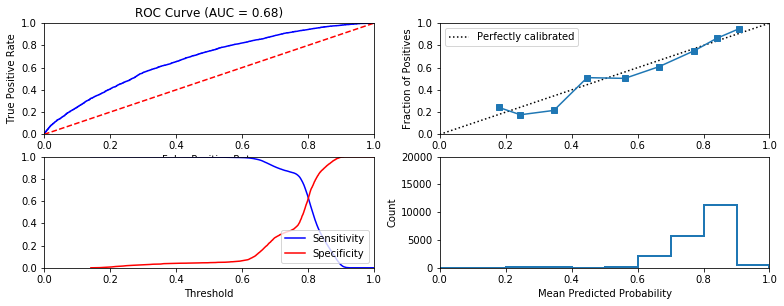


Similarity to LC grade ranking:  -0.4553338704592663
Brier score: 0.15044225524880472
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79986667]


In [16]:
#Q4
data_dict = prepare_data(feature_subset = final_features)
random_forest = fit_classification(RandomForestClassifier(max_depth=7,n_estimators=100), data_dict, model_name = 'Random Forest Classifier')

## Time stability test of YOURMODEL

  Model: Best Model
Fit time: 24.47 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.6708472933580889
Accuracy:  0.8527142857142858
              precision    recall  f1-score   support

  No default     0.2222    0.1314    0.1652       776
     Default     0.8970    0.9426    0.9192      6224

   micro avg     0.8527    0.8527    0.8527      7000
   macro avg     0.5596    0.5370    0.5422      7000
weighted avg     0.8222    0.8527    0.8356      7000



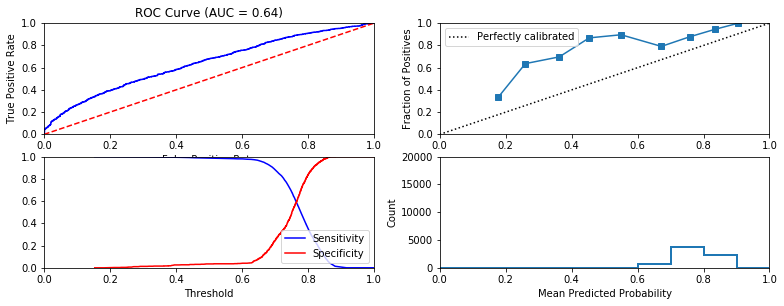


Similarity to LC grade ranking:  -0.3592157878807234
Brier score: 0.11220484384123434
Were parameters on edge? : True
Score variations around CV search grid : 0.8100679878489826
[0.76188889 0.76188889 0.76188889 0.76188889 0.76355556 0.765
 0.76533333 0.766      0.76622222 0.76666667 0.76766667 0.76788889
 0.76688889 0.76811111 0.76766667 0.76811111]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([ True,  True,  True, ...,  True,  True,  True]),
 'y_pred_probs': array([0.72025928, 0.80179637, 0.85155137, ..., 0.73578976, 0.82913261,
        0.69103976])}

In [17]:
## Define the time window of your train and test data - 2016, 2017
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = final_features)

## Train and test YOURMODEL using this data
cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}
best_model = RandomForestClassifier() #best model
fit_classification(best_model,data_dict_test,cv_parameters=cv_parameters,model_name='Best Model')

  Model: Best Model
Fit time: 25.84 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.7109317088186553
Accuracy:  0.8364285714285714
              precision    recall  f1-score   support

  No default     0.2006    0.1600    0.1780       775
     Default     0.8980    0.9206    0.9092      6225

   micro avg     0.8364    0.8364    0.8364      7000
   macro avg     0.5493    0.5403    0.5436      7000
weighted avg     0.8208    0.8364    0.8282      7000



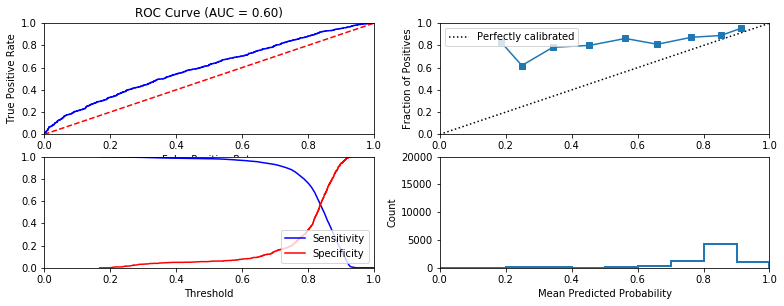


Similarity to LC grade ranking:  -0.6119712926090957
Brier score: 0.10619541604933712
Were parameters on edge? : True
Score variations around CV search grid : 0.7646671061305113
[0.83633333 0.83633333 0.83633333 0.83633333 0.83833333 0.83711111
 0.83977778 0.84088889 0.84011111 0.84188889 0.84222222 0.84177778
 0.841      0.84277778 0.84266667 0.84266667]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([ True,  True,  True, ...,  True, False,  True]),
 'y_pred_probs': array([0.78559238, 0.88627936, 0.90997243, ..., 0.8774483 , 0.61329531,
        0.77391015])}

In [18]:
## Define the time window of your train and test data - 2011, 2017
start_date_train = datetime.date(2011, 1, 1)
end_date_train = datetime.date(2011, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = final_features)

## Train and test YOURMODEL using this data
cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}
best_model = RandomForestClassifier() #best model
fit_classification(best_model,data_dict_test,cv_parameters=cv_parameters,model_name='Best Model')

## Train and test YOURMODEL on the original data

  Model: Best Model
Fit time: 96.39 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.5742297813292151
Accuracy:  0.8045
              precision    recall  f1-score   support

  No default     0.6190    0.1053    0.1799      4075
     Default     0.8112    0.9834    0.8890     15925

   micro avg     0.8045    0.8045    0.8045     20000
   macro avg     0.7151    0.5443    0.5345     20000
weighted avg     0.7720    0.8045    0.7445     20000



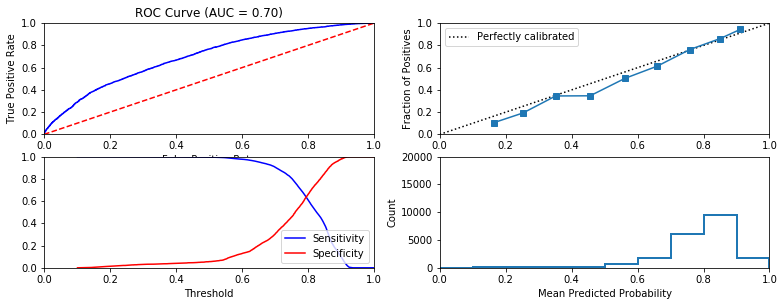


Similarity to LC grade ranking:  -0.7655776235623066
Brier score: 0.1470695782346822
Were parameters on edge? : True
Score variations around CV search grid : 0.9271963743711229
[0.79426667 0.79426667 0.79426667 0.79426667 0.7986     0.79873333
 0.79923333 0.79936667 0.80126667 0.8008     0.8009     0.80073333
 0.8014     0.8017     0.80136667 0.80166667]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([ True,  True, False, ...,  True,  True,  True]),
 'y_pred_probs': array([0.7717968 , 0.73253643, 0.54475692, ..., 0.87586905, 0.89417195,
        0.77172167])}

In [19]:
data_dict_test = prepare_data(feature_subset = your_features)

cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}
best_model = RandomForestClassifier() #best model
fit_classification(best_model,data_dict_test,cv_parameters=cv_parameters,model_name='Best Model')

## Test regression models

In [15]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [21]:
## First, trying l1 regularized linear regression with hyper-parameters

data_dict = prepare_data(feature_subset = final_features)
cv_parameters = {'alpha' : [10, 1, .1, .001,.0001]}

reg_lasso = fit_regression(linear_model.Lasso(),data_dict,cv_parameters=cv_parameters,model_name='Reg lasso')

  Model: Reg lasso  Return column: ret_PESS
Fit time: 2.14 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.02731985356625577
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -25.433092607169915
All test scores : [-0.12506858 -0.12506858 -0.10773897 -0.0997094  -0.09997448]
  Model: Reg lasso  Return column: ret_OPT
Fit time: 2.71 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.013337929668270854
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -47.86854455156189
All test scores : [-0.0245034  -0.0245034  -0.01866539 -0.01657107 -0.01687226]
  Model: Reg lasso  Return column: ret_INTa
Fit time: 2.14 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.04017785639569538
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -47.87030599668611
All test scores : [-0.10926163 -0.10926163 -0.0855758  -0.07389018 -0.07416265]
  Mode

In [18]:
# data_dict = prepare_data(feature_subset = final_features)
cv_parameters = {'alpha' : [10, 1, .1, .001,.0001]}

reg_lasso = fit_regression(linear_model.Lasso(),data_dict,cv_parameters=cv_parameters,model_name='Reg lasso - default and non-default loans', separate=True)

  Model: Reg lasso - default and non-default loans  Return column: ret_PESS
Fit time: 4.04 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.08702489347233311
model_1: 0.03198232006651336
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -78.81952730741641
All test scores : [-0.24590637 -0.2216085  -0.13751651 -0.13946703 -0.14107584]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -11.802891974078907
All test scores : [-0.4261594  -0.4261594  -0.41901747 -0.38117028 -0.3827095 ]
  Model: Reg lasso - default and non-default loans  Return column: ret_OPT
Fit time: 5.43 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.08611020029884775
model_1: 0.08323751729104711
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -77.95877802205273
All test sco

### $l_2$ regularized linear regressor

In [22]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha' : [10, 1, .1, .001,.0001]}

reg_ridge = fit_regression(linear_model.Ridge(),data_dict,cv_parameters=cv_parameters,model_name='Reg Ridge')

  Model: Reg Ridge  Return column: ret_PESS
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.027269880664929635
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.1182202154726304
All test scores : [-0.09897812 -0.09975005 -0.10003521 -0.10008443 -0.10008491]
  Model: Reg Ridge  Return column: ret_OPT
Fit time: 0.72 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.013112296811271906
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.6809686638186727
All test scores : [-0.016763   -0.01691464 -0.01702375 -0.01704457 -0.01704478]
  Model: Reg Ridge  Return column: ret_INTa
Fit time: 0.48 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.04014367819410125
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.254309882860761
All test scores : [-0.0734029  -0.07397636 -0.07426606 -0.07432303 -0.0743236 ]
  Model: Reg Rid

In [19]:
cv_parameters = {'alpha' : [10, 1, .1, .001,.0001]}

reg_ridge = fit_regression(linear_model.Ridge(),data_dict,cv_parameters=cv_parameters,model_name='Reg Ridge - default and non-default loans', separate=True)

  Model: Reg Ridge - default and non-default loans  Return column: ret_PESS
Fit time: 0.96 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.08761241246863494
model_1: 0.03272198677059723
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -3.319796163685834
All test scores : [-0.13676755 -0.13931873 -0.14089821 -0.1413036  -0.14130795]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -1.3376327783359694
All test scores : [-0.37836774 -0.38180327 -0.38320116 -0.38342671 -0.38342891]
  Model: Reg Ridge - default and non-default loans  Return column: ret_OPT
Fit time: 0.64 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.08627141917418091
model_1: 0.08017721043839987
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -4.7598534035228015
All test scores : [-0.

### Multi-layer perceptron regressor

In [23]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : [0.00001, 0.001, 0.1, 1, 10]}

reg_mlp = fit_regression(MLPRegressor(),data_dict,cv_parameters=cv_parameters,model_name='Multi Layer Perceptron Regress')

  Model: Multi Layer Perceptron Regress  Return column: ret_PESS
Fit time: 573.81 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 1}

Testing r2 score: 0.03651852539494538
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -33.2934767434107
All test scores : [-0.10475083 -0.10003554 -0.09845651 -0.09149931 -0.10621423 -0.09601211
 -0.10042951 -0.10532845 -0.09873609 -0.09542957 -0.0900599  -0.08884251
 -0.10147279 -0.08584901 -0.11167799 -0.11443113 -0.10029786 -0.11359286
 -0.09716963 -0.10048149]
  Model: Multi Layer Perceptron Regress  Return column: ret_OPT
Fit time: 600.57 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 1}

Testing r2 score: 0.02414364954367454
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -1039.6859510563586
All test scores : [-0.01555023 -0.0180912  -0.01305627 -0.01662087 -0.02356373 -0.01227746
 -0.01870163 -0.02090368 -0.01963299 -0.02156307 -0.01433201 -0

In [20]:
cv_parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : [0.00001, 0.001, 0.1, 1, 10]}

reg_mlp = fit_regression(MLPRegressor(),data_dict,cv_parameters=cv_parameters,model_name='Multi Layer Perceptron Regress- default and non-default loans', separate=True)

  Model: Multi Layer Perceptron Regress- default and non-default loans  Return column: ret_PESS
Fit time: 1254.0 seconds
Optimal parameters:
model_0: {'activation': 'identity', 'alpha': 1} model_1 {'activation': 'identity', 'alpha': 1}

Testing r2 scores:
model_0: 0.08742215790731289
model_1: 0.032073906948420605
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -34.52045609166415
All test scores : [-0.13733148 -0.13247775 -0.15941009 -0.12363051 -0.13561769 -0.13538733
 -0.13993379 -0.13436683 -0.12931805 -0.1441741  -0.14721316 -0.14293949
 -0.13857735 -0.14579779 -0.13926961 -0.15935174 -0.1492305  -0.16169509
 -0.16630833 -0.13791443]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -29.976661840386875
All test scores : [-0.3999083  -0.37209388 -0.35823114 -0.34124418 -0.37511306 -0.35955021
 -0.38243124 -0.4206303  -0.37473249 -0.41980845 -0.40157543 -0.34515414
 -0.38645762 -0.40398357 -0.3438406

### Random forest regressor

In [24]:
## trying random forest regression with hyper-parameters

cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}

reg_rf = fit_regression(RandomForestRegressor(),data_dict,cv_parameters=cv_parameters,model_name='Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 226.18 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 100}

Testing r2 score: 0.039682361399365096
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -22.358492217187088
All test scores : [-0.09833044 -0.09876913 -0.09927027 -0.09879854 -0.08944258 -0.08899599
 -0.08816282 -0.08829745 -0.08641459 -0.08412356 -0.08375858 -0.08402349
 -0.08419593 -0.08113068 -0.08141079 -0.08123685]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 242.68 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 400}

Testing r2 score: 0.029111078645917
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 207.6291713909573
All test scores : [-3.12587634e-03 -2.68147451e-03 -2.70301230e-03 -2.47022644e-03
  1.23918709e-04 -3.59058573e-04 -9.87068861e-05  1.19983918e-04
  1.66314981e-03  1.82067756e-03  2.15880882e-03  2.14989212e-03
 

In [21]:
cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}

reg_rf = fit_regression(RandomForestRegressor(),data_dict,cv_parameters=cv_parameters,model_name='Random Forest Regressor - default and non-default loans', separate=True)

  Model: Random Forest Regressor - default and non-default loans  Return column: ret_PESS
Fit time: 233.23 seconds
Optimal parameters:
model_0: {'max_depth': 5, 'n_estimators': 100} model_1 {'max_depth': 5, 'n_estimators': 250}

Testing r2 scores:
model_0: 0.08889249299269297
model_1: 0.053305178302370915
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -10.772629677610038
All test scores : [-0.13725685 -0.13797795 -0.1360624  -0.13553565 -0.13569918 -0.13170145
 -0.13259071 -0.13181329 -0.14354513 -0.12958537 -0.12983151 -0.13091094
 -0.13891588 -0.13590604 -0.13341127 -0.13333157]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -20.4270599942167
All test scores : [-0.40938336 -0.40691042 -0.40614225 -0.40551904 -0.35234189 -0.35484375
 -0.35403819 -0.35224726 -0.3444999  -0.34144596 -0.339943   -0.34122012
 -0.35869315 -0.3405389  -0.34158396 -0.34204757]
  Model: Random Forest Regressor - defaul

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [17]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

  Model: Best Classifier
Fit time: 18.57 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.6612641237188321
Accuracy:  0.80235
             precision    recall  f1-score   support

 No default     0.5641    0.1318    0.2136      4075
    Default     0.8143    0.9739    0.8870     15925

avg / total     0.7633    0.8024    0.7498     20000



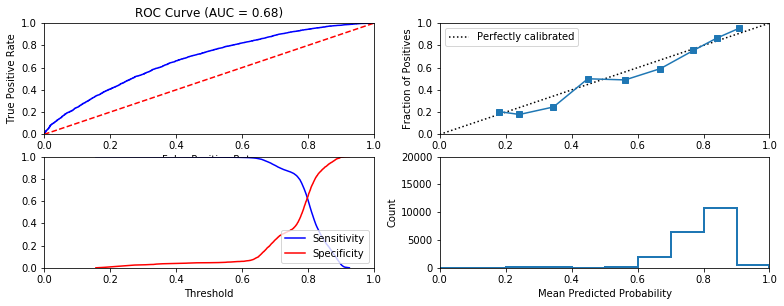


Similarity to LC grade ranking:  -0.4573092264028717
Brier score: 0.15048218909610772
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79986667]
  Model: Best Regressor  Return column: ret_PESS
Fit time: 76.45 seconds
Optimal parameters:
{}

Testing r2 score: 0.0396935813924546
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.08163173]
  Model: Best Regressor  Return column: ret_OPT
Fit time: 76.42 seconds
Optimal parameters:
{}

Testing r2 score: 0.029169626548944394
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 0.0
All test scores : [0.00298801]
  Model: Best Regressor  Return column: ret_INTa
Fit time: 76.47 seconds
Optimal parameters:
{}

Testing r2 score: 0.06462638339126292
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.04164225]
  Model: Best Regressor  Return column: re

ret_PESS: 0.5191337453411675
ret_OPT: 4.230455619397174
ret_INTa: 1.792795702818414
ret_INTb: 5.300098315111116
ret_PESS: 0.2836636120642972
ret_OPT: 3.481912144262469
ret_INTa: 1.6903404641752857
ret_INTb: 5.431851687451482
ret_PESS: 0.1718192709999241
ret_OPT: 3.848701082115118
ret_INTa: 2.1160589515935344
ret_INTb: 5.582584052299131
ret_PESS: 0.21352683775135758
ret_OPT: 4.535139127283097
ret_INTa: 2.1513889592417303
ret_INTb: 5.278157838093989
ret_PESS: 0.3524212432175409
ret_OPT: 4.452085617759958
ret_INTa: 1.6047521058443948
ret_INTb: 5.76612443644268
ret_PESS: 0.2231906828937652
ret_OPT: 4.095707122035155
ret_INTa: 2.0145696027067186
ret_INTb: 5.0644624155953695
ret_PESS: 0.6242909112218559
ret_OPT: 4.460600964056636
ret_INTa: 2.0981710323128655
ret_INTb: 5.4851745324063925
ret_PESS: 0.520382581724933
ret_OPT: 4.801383916658544
ret_INTa: 1.7333790215937666
ret_INTb: 5.13143010915881
ret_PESS: 0.047468440593583794
ret_OPT: 4.590137066630777
ret_INTa: 1.8705152604737878
ret_INTb: 

In [20]:
## Test investment strategies using the best performing regressor
data_dict = prepare_data(feature_subset = final_features) 

best_model1 = RandomForestClassifier(n_estimators=400, max_depth = 7) #best model
best_classifier = fit_classification(best_model1,data_dict,model_name='Best Classifier')
best_model2 = RandomForestRegressor(n_estimators=400, max_depth = 7) #best model
best_regressor = fit_regression(best_model2,data_dict,model_name='Best Regressor')

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

out_random =  [[],[],[],[]]

print('strategy:',test_strategy)   

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    strat_rand = test_investments(data_dict,regressor=best_regressor,classifier=best_classifier,strategy = test_strategy)
    j=0
    for ret_col in col_list:
        print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
        out_random[j].append(strat_rand[ret_col]['average return'])
        j=j+1

print('Mean of 100 iterations(ret_PESS,ret_OPT,ret_INTa,ret_INTb) : ',np.mean(out_random[0]),
      np.mean(out_random[1]),np.mean(out_random[2]),np.mean(out_random[3]))

In [24]:
test_strategy = 'Default-based'

out_default = [[],[],[],[]]

print('strategy:',test_strategy)   

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    strat_rand = test_investments(data_dict,regressor=best_regressor,classifier=best_classifier,strategy = test_strategy)
    j=0
    for ret_col in col_list:
        print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
        out_default[j].append(strat_rand[ret_col]['average return'])
        j=j+1

print('Mean of 100 iterations(ret_PESS,ret_OPT,ret_INTa,ret_INTb) : ',np.mean(out_default[0]),
      np.mean(out_default[1]),np.mean(out_default[2]),np.mean(out_default[3]))

strategy: Default-based
ret_PESS: -5.498880532444749
ret_OPT: 5.030724779169002
ret_INTa: 2.373275224700116
ret_INTb: 5.326241604076902
ret_PESS: 0.16508041882748892
ret_OPT: 4.563721677748496
ret_INTa: 2.0745495488751784
ret_INTb: 5.480328757565581
ret_PESS: -0.06194843503842287
ret_OPT: 4.649883818795485
ret_INTa: 2.1303604081386287
ret_INTb: 4.987384455997875
ret_PESS: -0.3162390620234706
ret_OPT: 4.472470459742241
ret_INTa: 2.0490767849250484
ret_INTb: 5.167092763948992
ret_PESS: 0.17965679280768132
ret_OPT: 4.454012483335582
ret_INTa: 2.125434754134107
ret_INTb: 5.141251462238235
ret_PESS: -0.31892547093316714
ret_OPT: 4.0945109751908495
ret_INTa: 1.5618560302588211
ret_INTb: 5.248182779419024
ret_PESS: 0.14433494019692933
ret_OPT: 4.45039267693397
ret_INTa: 1.7968644672052296
ret_INTb: 5.268136500697845
ret_PESS: -0.2108804462046232
ret_OPT: 3.1902495266896715
ret_INTa: 2.1538577043737903
ret_INTb: 4.916733515647737
ret_PESS: 0.11024494564162063
ret_OPT: 4.170695035450794
ret_INT

ret_PESS: 0.05395535341812757
ret_OPT: 3.872368700441584
ret_INTa: 2.213841550569462
ret_INTb: 5.444863574250412
ret_PESS: 0.12863888311200322
ret_OPT: 4.0550339553478665
ret_INTa: 2.4163567900570087
ret_INTb: 5.432947043973061
ret_PESS: 0.21865556426335764
ret_OPT: 4.416845371554376
ret_INTa: 2.013097025048509
ret_INTb: 5.026374714274264
ret_PESS: 0.12327129911432917
ret_OPT: 4.222557205807772
ret_INTa: 2.11278656809287
ret_INTb: 5.340056533901442
ret_PESS: -0.3506281612380146
ret_OPT: 3.913245491083388
ret_INTa: 1.8458625981008547
ret_INTb: 5.3513732746851
ret_PESS: 0.10507224768524051
ret_OPT: 4.134323816183263
ret_INTa: 2.1903349792137004
ret_INTb: 5.535238626722201
ret_PESS: -0.13907802797716884
ret_OPT: 3.9692145595977415
ret_INTa: 2.2588257681638186
ret_INTb: 5.545412361524447
ret_PESS: -0.15653877880004194
ret_OPT: 3.8254405095916897
ret_INTa: 2.2261194416433163
ret_INTb: 5.35240983921504
ret_PESS: -0.11411926120552218
ret_OPT: 4.3119989335304565
ret_INTa: 1.919137150449521
ret

In [25]:
test_strategy = 'Return-based'

out_return =  [[],[],[],[]]

print('strategy:',test_strategy)   

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    strat_rand = test_investments(data_dict,regressor=best_regressor,classifier=best_classifier,strategy = test_strategy)
    j=0
    for ret_col in col_list:
        print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
        out_return[j].append(strat_rand[ret_col]['average return'])
        j=j+1

print('Mean of 100 iterations(ret_PESS,ret_OPT,ret_INTa,ret_INTb) : ',np.mean(out_return[0]),
      np.mean(out_return[1]),np.mean(out_return[2]),np.mean(out_return[3]))

strategy: Return-based
ret_PESS: 1.7101408080826586
ret_OPT: 4.214495547531214
ret_INTa: 1.8189119238275706
ret_INTb: 5.474423358653736
ret_PESS: 0.6332904510574813
ret_OPT: 4.700681501272336
ret_INTa: 1.7505283358361625
ret_INTb: 5.856538158415543
ret_PESS: 0.8929712407607943
ret_OPT: 4.526463668266926
ret_INTa: 2.2246816164665897
ret_INTb: 5.434370729702938
ret_PESS: 0.779267652588772
ret_OPT: 4.445578804664368
ret_INTa: 2.069609096168314
ret_INTb: 5.005082781389632
ret_PESS: 0.4982025458323618
ret_OPT: 3.622437573343117
ret_INTa: 1.8745673513866086
ret_INTb: 4.945940132436214
ret_PESS: 0.3908893381237916
ret_OPT: 4.158097055393344
ret_INTa: 2.1034671667295224
ret_INTb: 5.74984571891741
ret_PESS: 0.8771829017911545
ret_OPT: 4.256824656542846
ret_INTa: 2.5318837870473985
ret_INTb: 5.642592648797099
ret_PESS: 0.6765521476010513
ret_OPT: 4.498278644296863
ret_INTa: 1.7263284279021331
ret_INTb: 5.311400039388885
ret_PESS: 1.164352134358844
ret_OPT: 4.547942084234277
ret_INTa: 2.053459434

ret_PESS: 0.6500942650374143
ret_OPT: 3.7745588736271625
ret_INTa: 2.0145037896860103
ret_INTb: 5.3935494313223025
ret_PESS: 0.4537945982107676
ret_OPT: 4.167935439724831
ret_INTa: 1.958902557982952
ret_INTb: 5.436641478926503
ret_PESS: 1.4222261182016795
ret_OPT: 4.4742158370849365
ret_INTa: 2.176997122710709
ret_INTb: 5.204882606037232
ret_PESS: 0.8562447984279602
ret_OPT: 4.076409776539826
ret_INTa: 1.6851799267343166
ret_INTb: 5.319337211421131
ret_PESS: 1.2851097485796927
ret_OPT: 4.412147970374416
ret_INTa: 1.7347424589288472
ret_INTb: 5.080018380846104
ret_PESS: 1.0094343678453543
ret_OPT: 4.462378624443786
ret_INTa: 2.1943946065939497
ret_INTb: 5.645735677141037
ret_PESS: 0.7288103758295839
ret_OPT: 4.823974862793055
ret_INTa: 2.189075741516413
ret_INTb: 5.1103869121559695
ret_PESS: 0.9157666405979291
ret_OPT: 4.658116460514589
ret_INTa: 2.3022958634819295
ret_INTb: 5.228088704147005
ret_PESS: 0.7540357507762969
ret_OPT: 4.524306437970749
ret_INTa: 1.9033159394769945
ret_INTb: 

In [26]:
test_strategy = 'Default-return-based'

out_dr = [[],[],[],[]]
## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'max_depth':[1,3,5,7],'n_estimators':[10,100,250,400]}

reg_separate = fit_regression(RandomForestRegressor(),data_dict,cv_parameters=cv_parameters,model_name='Random Forest Regressor',separate=True)

print('strategy:',test_strategy)

for i in range(0,100):
    data_dict = prepare_data(feature_subset = final_features, random_state = i+1) 
    strat_rand = test_investments(data_dict,regressor=reg_separate,classifier=best_classifier,strategy = test_strategy)
    j=0
    for ret_col in col_list:
        print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
        out_dr[j].append(strat_rand[ret_col]['average return'])
        j=j+1

print('Mean of 100 iterations(ret_PESS,ret_OPT,ret_INTa,ret_INTb) : ',np.mean(out_dr[0]),
np.mean(out_dr[1]),np.mean(out_dr[2]),np.mean(out_dr[3]))

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 254.65 seconds
Optimal parameters:
model_0: {'n_estimators': 100, 'max_depth': 3} model_1 {'n_estimators': 250, 'max_depth': 5}

Testing r2 scores:
model_0: 0.08976167437097238
model_1: 0.050128195411000664
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -17.933315995817402
All test scores : [-0.43065611 -0.4294945  -0.4305297  -0.42992097 -0.37599785 -0.37354356
 -0.37410441 -0.37369653 -0.37178151 -0.3658641  -0.36516917 -0.36576981
 -0.37734974 -0.37155398 -0.37231399 -0.37176352]
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -10.71558092900738
All test scores : [-0.18577508 -0.18829284 -0.18701262 -0.18674001 -0.18832081 -0.18395517
 -0.18564393 -0.18517804 -0.18658276 -0.18617125 -0.18539098 -0.18423648
 -0.20366703 -0.18763653 -0.18537516 -0.18720804]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 245.6

ret_PESS: 0.6647072418316436
ret_OPT: 4.537433385461197
ret_INTa: 1.8257184912974085
ret_INTb: 5.510667953854835
ret_PESS: 0.6096832874360106
ret_OPT: 4.585735727730027
ret_INTa: 2.023657897061938
ret_INTb: 5.333063502440516
ret_PESS: 0.25855379837738407
ret_OPT: 3.8750566103022703
ret_INTa: 2.045123288766133
ret_INTb: 5.556456014044717
ret_PESS: 0.39178193104376
ret_OPT: 4.295851218277883
ret_INTa: 1.6812598723285113
ret_INTb: 5.20981530715651
ret_PESS: 0.237287845714711
ret_OPT: 3.936927074270555
ret_INTa: 2.2614923848733737
ret_INTb: 5.200942905557972
ret_PESS: 0.7214922312836735
ret_OPT: 4.363242686599049
ret_INTa: 2.336643245055051
ret_INTb: 5.070160793666437
ret_PESS: 1.232622944866569
ret_OPT: 4.3263175395857125
ret_INTa: 2.463381202623226
ret_INTb: 5.582122649772618
ret_PESS: 0.22275942260105383
ret_OPT: 3.3023489558691472
ret_INTa: 1.9073448244728677
ret_INTb: 5.267396025987189
ret_PESS: 0.3363449183146938
ret_OPT: 4.019425300211109
ret_INTa: 1.9555432291109995
ret_INTb: 5.436

## Sensitivity test of portfolio size

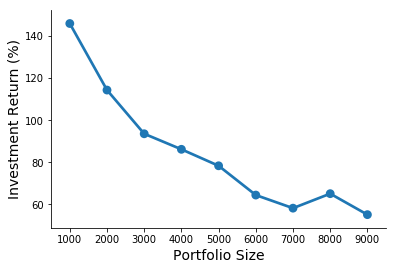

In [28]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []
test_strategy = 'Return-based'

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict,regressor=best_regressor,classifier=best_classifier,strategy = test_strategy,num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()